# Linear Dataset where t=1 is a linear function of t=0

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import seaborn as sns 

base_dir = Path(".").absolute().parents[0]
import sys

if sys.path[0] != base_dir.as_posix():
    sys.path = [base_dir.as_posix()] + sys.path

In [2]:
from spatio_temporal.config import Config
from spatio_temporal.training.trainer import Trainer
from spatio_temporal.training.tester import Tester
from tests.utils import (
    create_linear_ds,
    _test_sklearn_model,
    get_pollution_data_beijing,
)
from spatio_temporal.data.data_utils import _stack_xarray
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_losses

# Load in Data

In [3]:
ds = create_linear_ds(epsilon_sigma=10)
ds

<xarray.Dataset>
Dimensions:  (lat: 10, lon: 10, time: 252)
Coordinates:
  * lat      (lat) float64 -55.15 -40.69 -26.22 -11.76 ... 46.1 60.56 75.02
  * lon      (lon) float64 -180.0 -140.0 -100.0 -60.0 ... 60.0 100.0 140.0 180.0
  * time     (time) datetime64[ns] 2000-01-31 2000-02-29 ... 2020-12-31
Data variables:
    feature  (lat, lon, time) float64 29.0 81.0 51.0 57.0 ... 8.0 47.0 59.0 nan
    target   (lat, lon, time) float64 51.29 121.6 282.1 ... 30.18 177.6 209.1

# Load in Config File

In [4]:
cfg = Config(base_dir / "configs/test_config.yml")
cfg._cfg["scheduler"] = "cycle"
cfg._cfg["optimizer"] = "adamw"
cfg._cfg["model"] = "lstm"  # "lstm"   "bilstm"
cfg._cfg["early_stopping"] = 2
cfg._cfg["n_epochs"] = 4
cfg._cfg["batch_size"] = 100
cfg._cfg["encode_doys"] = True
cfg._cfg["static_inputs"] = "embedding"
cfg._cfg["forecast_variables"] = ["feature"]
cfg._cfg["num_workers"] = 0
cfg

{'autoregressive': False,
 'batch_size': 100,
 'data_dir': PosixPath('data'),
 'early_stopping': 2,
 'encode_doys': True,
 'experiment_name': 'test',
 'forecast_variables': ['feature'],
 'hidden_size': 64,
 'horizon': 1,
 'input_variables': ['feature'],
 'learning_rate': 0.01,
 'loss': 'MSE',
 'model': 'lstm',
 'n_epochs': 4,
 'num_workers': 0,
 'optimizer': 'adamw',
 'run_dir': None,
 'scheduler': 'cycle',
 'seed': 1234,
 'seq_length': 1,
 'static_inputs': 'embedding',
 'target_variable': 'target',
 'test_end_date': Timestamp('2020-12-31 00:00:00'),
 'test_start_date': Timestamp('2016-01-31 00:00:00'),
 'train_end_date': Timestamp('2015-12-31 00:00:00'),
 'train_start_date': Timestamp('2003-01-31 00:00:00'),
 'validation_end_date': Timestamp('2002-12-31 00:00:00'),
 'validation_start_date': Timestamp('2000-01-31 00:00:00')}

# Create Trainer

In [5]:
trainer = Trainer(cfg, ds)

if cfg.static_inputs is None:
    assert trainer.train_dl.static_input_size == 0
else:
    assert trainer.train_dl.static_input_size == 100

Loading Data: 100%|██████████| 100/100 [00:00<00:00, 343.98it/s]


In [6]:
len(trainer.train_dl)
trainer.train_dl.batch_size

100

In [7]:
losses = trainer.train_and_validate()

Training Epoch 2:   9%|▉         | 14/154 [00:00<00:01, 136.89it/s, 0.08 -- LR 4.02e-04]

Train Loss: 0.58
Valid Loss: 0.09


Training Epoch 3:   9%|▉         | 14/154 [00:00<00:01, 137.67it/s, 0.03 -- LR 4.08e-04]

Train Loss: 0.05
Valid Loss: 0.04


Training Epoch 4:   9%|▉         | 14/154 [00:00<00:01, 134.36it/s, 0.03 -- LR 4.17e-04]

Train Loss: 0.03
Valid Loss: 0.03


Validation Epoch 4: 100%|██████████| 34/34 [00:00<00:00, 247.59it/s]

Train Loss: 0.03
Valid Loss: 0.03


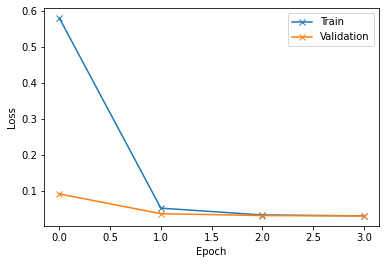

In [8]:
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_loss_curves

save_loss_curves(losses, cfg)
# _plot_loss_curves(losses);

Text(0, 0.5, '$\\Delta$ Validation Losses')

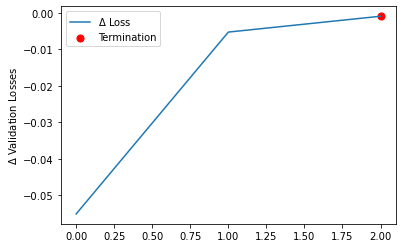

In [9]:
train_losses, valid_losses = losses
plt.plot(np.diff(valid_losses), label="$\Delta$ Loss")
np.diff(valid_losses)

idx = np.argmin(valid_losses) - 1
plt.scatter(idx, np.diff(valid_losses)[idx], color="r", s=50, label="Termination")
plt.legend()
plt.ylabel("$\Delta$ Validation Losses")

# Load the trained data

In [10]:
tester = Tester(cfg, ds)

Loading Data: 100%|██████████| 100/100 [00:00<00:00, 303.73it/s]


Test set Forward Pass: 100%|██████████| 57/57 [00:00<00:00, 238.64it/s]


<xarray.Dataset>
Dimensions:  (pixel: 100, time: 57)
Coordinates:
  * time     (time) datetime64[ns] 2016-03-30T23:58:53.302898688 ... 2020-11-...
    horizon  int64 1
  * pixel    (pixel) object '-11.760000000000005_-100.0' ... '75.024_60.0'
Data variables:
    sim      (time, pixel) float64 70.49 254.0 305.0 233.5 ... 164.0 275.0 292.1
    obs      (time, pixel) float64 50.36 243.5 305.2 222.4 ... 177.6 278.9 282.1

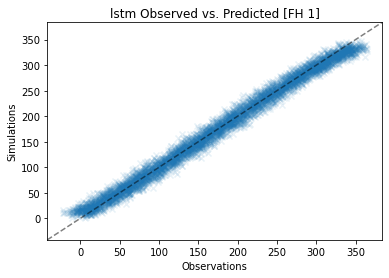

In [11]:
tester.run_test()

# The output forecasts! 

In [12]:
xr_path = sorted(list(cfg.run_dir.glob("*.nc")))[-1]
preds = xr.open_dataset(xr_path).drop("horizon")
preds

<xarray.Dataset>
Dimensions:  (pixel: 100, time: 57)
Coordinates:
  * time     (time) datetime64[ns] 2016-03-30T23:58:53.302898688 ... 2020-11-...
  * pixel    (pixel) object '-11.760000000000005_-100.0' ... '75.024_60.0'
Data variables:
    sim      (time, pixel) float64 ...
    obs      (time, pixel) float64 ...

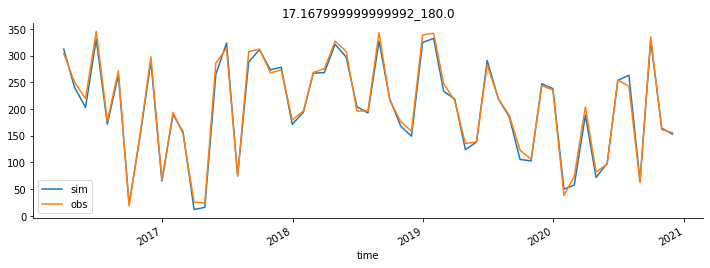

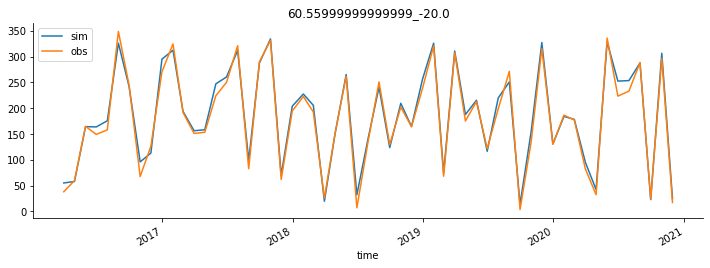

In [13]:
from spatio_temporal.training.eval_utils import save_timeseries

for _ in range(2):
    save_timeseries(preds, cfg)
    sns.despine()

In [14]:
stacked, sample = _stack_xarray(ds, cfg.pixel_dims)